# The backgroup of the script

To plot a distribution plot of RMSD group by temperature, pH, IS across 54 runs so as to i) compare with the plots generated from 20 runs, ii) to grasp an idea of the distribution of RMSD in different conditions


Update 13/09/23

Also to perform pearson regression analysis and PLS in python with the RMSF value.

## Distribution plot

In [1]:
# To create a reusable function that reads XVG data from a file and saves it into a dataframe
# Of course it is not perfect. The column names are not specified since rmsd, rmsf, gyrate differs, and it is a bit tricky to specify it since gyrate has four columns instead of two like the other two


import pandas as pd

def read_xvg(file_path):
    data = []

    with open(file_path, 'r') as f:
        for line in f:
            if not line.startswith("#") and not line.startswith('@'):
                new_list = [elem for elem in line.split()]
                data.append(new_list)
    # Convert the list of lists into a Pandas DataFrame
    df = pd.DataFrame(data)
    return df

In [2]:
xvgpath = 'XVGfiles54runs/' # change it everytime if you have a new␣ ↪directory
# reference: https://stackoverflow.com/questions/55245721/ ↪read-in-multiple-csv-into-separate-dataframes-in-pandas
# https://stackoverflow.com/questions/36294712/ ↪python-filename-contains-string-metachar
# https://www.delftstack.com/howto/python/python-fnmatch/
# save rmsd, rmsf, gyrate files into different dictionaries

import os
import pandas as pd
import fnmatch # looking for a specific string in a file name
directory = xvgpath
# rmsd files
rmsd = [x for x in os.listdir(directory) if fnmatch.fnmatch(x, '*rmsd*.xvg')] # fnmatch look for rmsd filename specifically
# rmsf
rmsf = [x for x in os.listdir(directory) if fnmatch.fnmatch(x, '*rmsf*.xvg')]
# gyrate
gyrate = [x for x in os.listdir(directory) if fnmatch.fnmatch(x,'*gyrate*.xvg')]

## example for fnmatch: the files that start with hello and end with .js `if␣ ↪fnmatch.fnmatch(file, "hello*.js"):`
d_rmsd = {} # dictionary that will hold them 
d_rmsf = {}
d_gyrate = {}

for file_name in rmsd: # loop over files
   # read data into a dataframe and add it to dict with file_name as it key
    d_rmsd[file_name] = read_xvg(os.path.join(directory,file_name)) # to note, directory and file_name need to be joint or else the file can't be␣ ↪found
for file_name in rmsf: # loop over files
# read data into a dataframe and add it to dict with file_name as it key
    d_rmsf[file_name] = read_xvg(os.path.join(directory,file_name)) 
for file_name in gyrate: # loop over files
   # read data into a dataframe and add it to dict with file_name as it key
    d_gyrate[file_name] = read_xvg(os.path.join(directory,file_name))

### drop first 50ns and save all the conditions into one dataframe (without mean calculation at this step) - not in use anymore. The plots were not that good

In [13]:
# Drop the first 50 ns of RMSD

import re

d_rmsd_drop = {}
for df in d_rmsd: # loop over the dictionary. df is the key of the dictionary␣ ↪https://www.w3schools.com/python/python_dictionaries_loop.aspb
    d_rmsd_drop[df] = d_rmsd[df].drop(range(0,501))
    
  
# Temperature comparison

result_t={} # should contain all the rmsd data grouped by temperature in this␣ ↪dictionary after running this commmand
for i in ['277','296','318','338']: #loop over temperature frames_t = list()
    
    frames_t = []
    for key in d_rmsd_drop:
        if re.search('(.+)'+ i +'(.+)', key): # be very careful with the variable when you use it with the wildcard together. You should use it like␣ ↪it is in the left. https://www.tutorialspoint.com/ ↪how-to-use-variables-in-python-regular-expression
            frames_t.append(d_rmsd_drop[key])

    merge = pd.concat(frames_t) # merge dataframes
    merge = merge.reset_index(drop=True) #reset index
    merge = merge.assign(Temp = i + 'K') # generate a new column called temperature which can be useful in future when combining different temp␣ ↪dataframes and plot distribution

    result_t[i + 'K'] = merge # save into the result_t dictionary
    
    
# drop time column
result_dist={}
for key in result_t:
    result_dist[key] = result_t[key].drop(columns=result_t[key].columns[0]) # drop time column

# combine all the dataframes in result_dist together

frames = []

for key in result_dist: 
    frames.append(result_dist[key])

    
#result_comb = pd.DataFrame (frames, columns = ['RMSD', 'Temp'])
# Note, you cannot use the command above. Because the data inside frames is actually DATAFRAME instead of LISTS
    
result_comb = pd.concat(frames,ignore_index=True) # merge dataframes # The ignore_index=True argument ensures that the resulting DataFrame has a continuous index. 
result_comb.columns = ['RMSD', 'Temp'] # assign column names


In [14]:
result_comb

,RMSD,Temp
0,0.3045818,277K
1,0.3078314,277K
2,0.3203286,277K
3,0.3273042,277K
4,0.3215064,277K
...,...,...
161995,0.4377436,338K
161996,0.4143789,338K
161997,0.4253831,338K
161998,0.3998747,338K


162000 = 500 frames * 54 runs * 6 replicas

#### Distribution plot

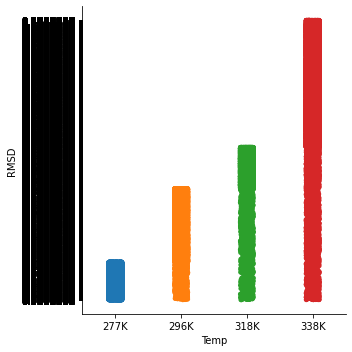

In [6]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pdb


sns.catplot(data=result_comb, x="Temp", y="RMSD")

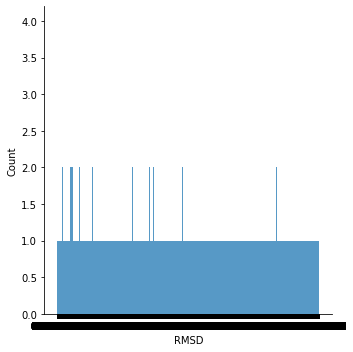

In [15]:
# the datapoints are huge and therefore it takes really long to plot it
# I wonder how it will go in myriad. It should be much quicker

sns.displot(result_comb, x="RMSD")

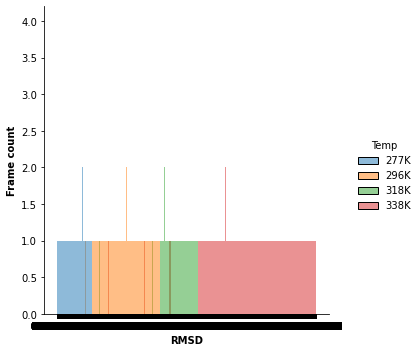

In [16]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pdb

ax = sns.displot(result_comb, x="RMSD", hue="Temp") # use displot to generate histogram, https://seaborn.pydata.org/tutorial/ ↪distributions.html
plt.xlabel('RMSD', fontstyle='normal', weight=700) # bold the x label 
plt.ylabel('Frame count', fontstyle='normal', weight=700) # rename the y lable␣(previously it was 'count') and bold it as well https://www.statology.org/seaborn-axis-labels/ 
plt.show()
#plt.savefig('RMSD_temperature_distribution190722.png', dpi = 300) # save the figure in high-resolution https://www.marsja.se/ ↪how-to-save-a-seaborn-plot-as-a-file-e-g-png-pdf-eps-tiff/

ValueError: cannot set using a list-like indexer with a different length than the value

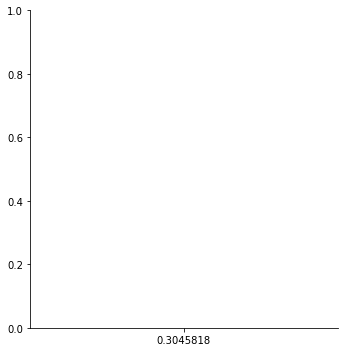

In [56]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pdb

# plot a histogram + KDE (overlaid)
ax = sns.displot(df_20ns), x="RMSD", hue="Temp", element="bars", kde='True', kind = 'hist') # use displot to generate histogram, https://seaborn. ↪pydata.org/tutorial/distributions.html
plt.xlabel('RMSD', fontstyle='normal', weight=700) # bold the x label 
plt.ylabel('Frame count', fontstyle='normal', weight=700) # rename the y lable␣(previously it was 'count') and bold it as well https://www.statology.org/seaborn-axis-labels/ 
#plt.savefig('54RMSD_temperature_Histogram_KDE030923.png', dpi = 500) # save the␣figure in high-resolution https://www.marsja.se/ ↪how-to-save-a-seaborn-plot-as-a-file-e-g-png-pdf-eps-tiff/
plt.show()   
 


In [ ]:
# plot a Gaussian Kernel Density Estimation (KDE)
ax = sns.displot(result_comb, x="RMSD", hue="Temp", kind = 'kde') # use displot to generate histogram, https://seaborn.pydata.org/tutorial/distributions.html

plt.xlabel('RMSD', fontstyle='normal', weight=700) # bold the x label 
plt.ylabel('Frame count', fontstyle='normal', weight=700) # rename the y lable␣(previously it was 'count') and bold it as well https://www.statology.org/↪seaborn-axis-labels/
plt.savefig('54RMSD_temperature_KDE030923.png', dpi = 300) # save the figure in high-resolution

### Drop first 80ns and save all the conditions into one dataframe (without mean calculation at this step)

In [3]:
# Drop the first 80 ns of RMSD

import re

d_rmsd_drop = {}
for df in d_rmsd: # loop over the dictionary. df is the key of the dictionary␣ ↪https://www.w3schools.com/python/python_dictionaries_loop.aspb
    d_rmsd_drop[df] = d_rmsd[df].drop(range(0,801))
    
  
# Temperature comparison

result_t={} # should contain all the rmsd data grouped by temperature in this␣ ↪dictionary after running this commmand
for i in ['277','296','318','338']: #loop over temperature frames_t = list()
    
    frames_t = []
    for key in d_rmsd_drop:
        if re.search('(.+)'+ i +'(.+)', key): # be very careful with the variable when you use it with the wildcard together. You should use it like␣ ↪it is in the left. https://www.tutorialspoint.com/ ↪how-to-use-variables-in-python-regular-expression
            frames_t.append(d_rmsd_drop[key])
    #print(frames_t)
    merge = pd.concat(frames_t) # merge dataframes
    merge = merge.reset_index(drop=True) #reset index
    merge = merge.assign(Temp = i + 'K') # generate a new column called temperature which can be useful in future when combining different temp␣ ↪dataframes and plot distribution

    result_t[i + 'K'] = merge # save into the result_t dictionary
    
    
# drop time column
result_dist={}
for key in result_t:
    result_dist[key] = result_t[key].drop(columns=result_t[key].columns[0]) # drop time column

# combine all the dataframes in result_dist together

frames = []

for key in result_dist: 
    frames.append(result_dist[key])

    
#result_comb = pd.DataFrame (frames, columns = ['RMSD', 'Temp'])
# Note, you cannot use the command above. Because the data inside frames is actually DATAFRAME instead of LISTS
    
df_20ns = pd.concat(frames,ignore_index=True) # merge dataframes # The ignore_index=True argument ensures that the resulting DataFrame has a continuous index. 
df_20ns.columns = ['RMSD', 'Temp'] # assign column names


In [5]:
df_20ns

,RMSD,Temp
0,0.2585794,277K
1,0.2772596,277K
2,0.2592770,277K
3,0.2723874,277K
4,0.2543541,277K
...,...,...
64795,0.4377436,338K
64796,0.4143789,338K
64797,0.4253831,338K
64798,0.3998747,338K


200 frames * 54 runs * 6 replicas = 64800

In [ ]:
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt 


ax = sns.displot(result_comb, x="RMSD", hue="Temp", kind = 'kde') # use displot to generate histogram, https://seaborn.pydata.org/tutorial/distributions.html

plt.xlabel('RMSD', fontstyle='normal', weight=700) # bold the x label 
plt.ylabel('Frame count', fontstyle='normal', weight=700) # rename the y lable␣(previously it was 'count') and bold it as well https://www.statology.org/↪seaborn-axis-labels/
plt.savefig('54RMSD_temperature_KDE030923.png', dpi = 300) # save the figure in high-resolution

plt.clf() # Clean parirplot figure from sns 
Image(filename='54RMSD_temperature_KDE030923.png') # Show pairplot as image

### Mean calculation

Several ways to calculate RMSD mean

i) One layer of average
for each frame in every condition, calcuate the RMSD mean (last 50ns), in this way, there will be 500frames * 54 runs in total of frames. (divide by 6 from the total number)

ii) Two layers of average
average all the frames in the last 20ns (or 50ns) first, and then average all the replicas. In this way, there will be 1 mean RMSD for all the 6 replicas, 54 datapoints in total

In this way hopefully the data size will be significantly reduced and therefore the distribution plot could be plotted more quickly and easily

In [83]:
# clean & extract conditions
# try out with 30 files

## update after one hour in trying out the code
## No longer needs this cell anymore
## I was stupid. Actually to achieve what I want there are really only three lines needed: first remove the suffix & r number & loop number; then strip the underscore; then just remove all the letters 

import re

pattern = r'loop\d{1}' # get rid of 'loop' and the one digit after it

for file in rmsd[:30]: # try this out for the first ten files
    a = file.split(".")[0] # get rid of the suffix .xvg
    display(a)

    a = re.sub(r'r\d{1}', '', a) # get rid of i.g. _r2
    print(a)

    b = re.sub(r'rmsd','',a) # get rid of rmsd
    print(b)
    
    b = b.strip('_')
    print(b)
    
    
    # comparing this with the command below actually this step isn't necessary. Just use re.sub directly. If it cannot find a pattern it will just skip it and look for the next one. It combines the searching i would say
    if re.search(pattern, b, re.IGNORECASE): # if there is a "loop" get rid of that too # case-insensitive search
        c = re.sub(pattern,'',b, flags =re.I)
    else:
        c = b
    c = c.strip('_')
    print(c)
    
    # remove any non-numerical letters; keep numbers and underscores
    d = re.sub(r"[^0-9_]", "", c)
#    d = c.strip('_') # this is the culprit. It should be d=d.strip('_')
    d=d.strip('_')
    print(d)

    


'5_5_296_250_r2_rmsd'

5_5_296_250__rmsd
5_5_296_250__
5_5_296_250
5_5_296_250
5_5_296_250


'9_338_200_r3_rmsd'

9_338_200__rmsd
9_338_200__
9_338_200
9_338_200
9_338_200


'5_5_296_250_r3_rmsd'

5_5_296_250__rmsd
5_5_296_250__
5_5_296_250
5_5_296_250
5_5_296_250


'9_338_200_r2_rmsd'

9_338_200__rmsd
9_338_200__
9_338_200
9_338_200
9_338_200


'loop5_r2_318_4_5_150M_3_rmsd'

loop5__318_4_5_150M_3_rmsd
loop5__318_4_5_150M_3_
loop5__318_4_5_150M_3
318_4_5_150M_3
5__318_4_5_150_3


'loop5_r2_318_4_5_150M_2_rmsd'

loop5__318_4_5_150M_2_rmsd
loop5__318_4_5_150M_2_
loop5__318_4_5_150M_2
318_4_5_150M_2
5__318_4_5_150_2


'loop6_r3_338_4_5_250M_rmsd'

loop6__338_4_5_250M_rmsd
loop6__338_4_5_250M_
loop6__338_4_5_250M
338_4_5_250M
6__338_4_5_250


'loop4_r5_296_4_5_50M_rmsd'

loop4__296_4_5_50M_rmsd
loop4__296_4_5_50M_
loop4__296_4_5_50M
296_4_5_50M
4__296_4_5_50


'loop3_r4_338_3_5_50M_rmsd'

loop3__338_3_5_50M_rmsd
loop3__338_3_5_50M_
loop3__338_3_5_50M
338_3_5_50M
3__338_3_5_50


'7_296_150_r1_rmsd'

7_296_150__rmsd
7_296_150__
7_296_150
7_296_150
7_296_150


'loop2_r5_318K_7_150M_rmsd'

loop2__318K_7_150M_rmsd
loop2__318K_7_150M_
loop2__318K_7_150M
318K_7_150M
2__318_7_150


'Loop1_r4_296K_7_50M_rmsd'

Loop1__296K_7_50M_rmsd
Loop1__296K_7_50M_
Loop1__296K_7_50M
296K_7_50M
1__296_7_50


'5_5_296_100_r6_rmsd'

5_5_296_100__rmsd
5_5_296_100__
5_5_296_100
5_5_296_100
5_5_296_100


'9_338_400_r6_rmsd'

9_338_400__rmsd
9_338_400__
9_338_400
9_338_400
9_338_400


'loop4_r1_296_4_5_50M_2_rmsd'

loop4__296_4_5_50M_2_rmsd
loop4__296_4_5_50M_2_
loop4__296_4_5_50M_2
296_4_5_50M_2
4__296_4_5_50_2


'loop2_r3_338K_7_50M_rmsd'

loop2__338K_7_50M_rmsd
loop2__338K_7_50M_
loop2__338K_7_50M
338K_7_50M
2__338_7_50


'loop3_r1_338_3_5_50M_rmsd'

loop3__338_3_5_50M_rmsd
loop3__338_3_5_50M_
loop3__338_3_5_50M
338_3_5_50M
3__338_3_5_50


'3_5_277_0_r3_rmsd'

3_5_277_0__rmsd
3_5_277_0__
3_5_277_0
3_5_277_0
3_5_277_0


'3_5_277_0_r2_rmsd'

3_5_277_0__rmsd
3_5_277_0__
3_5_277_0
3_5_277_0
3_5_277_0


'8_338_200_r2_rmsd'

8_338_200__rmsd
8_338_200__
8_338_200
8_338_200
8_338_200


'8_338_200_r3_rmsd'

8_338_200__rmsd
8_338_200__
8_338_200
8_338_200
8_338_200


'loop2_r2_338K_7_50M_rmsd'

loop2__338K_7_50M_rmsd
loop2__338K_7_50M_
loop2__338K_7_50M
338K_7_50M
2__338_7_50


'8_338_0_r2_rmsd'

8_338_0__rmsd
8_338_0__
8_338_0
8_338_0
8_338_0


'8_338_400_r6_rmsd'

8_338_400__rmsd
8_338_400__
8_338_400
8_338_400
8_338_400


'8_338_0_r3_rmsd'

8_338_0__rmsd
8_338_0__
8_338_0
8_338_0
8_338_0


'loop3_r3_277_3_5_150M_rmsd'

loop3__277_3_5_150M_rmsd
loop3__277_3_5_150M_
loop3__277_3_5_150M
277_3_5_150M
3__277_3_5_150


'Loop1_r5_296K_7_50M_rmsd'

Loop1__296K_7_50M_rmsd
Loop1__296K_7_50M_
Loop1__296K_7_50M
296K_7_50M
1__296_7_50


'loop2_r1_338K_7_50M_rmsd'

loop2__338K_7_50M_rmsd
loop2__338K_7_50M_
loop2__338K_7_50M
338K_7_50M
2__338_7_50


'5_5_296_50_r3_rmsd'

5_5_296_50__rmsd
5_5_296_50__
5_5_296_50
5_5_296_50
5_5_296_50


'5_5_296_50_r2_rmsd'

5_5_296_50__rmsd
5_5_296_50__
5_5_296_50
5_5_296_50
5_5_296_50


In [60]:
# clean & extract conditions
## no use anymore. See the cells below for comments and reasons

import re

pattern = r'loop\d{1}' # get rid of 'loop' and the one digit after it
run54 = []

for file in rmsd: # try this out for the first ten files
    a = file.split(".")[0] # get rid of the suffix .xvg

    a = re.sub(r'r\d{1}', '', a) # get rid of i.g. _r2

    b = re.sub(r'rmsd','',a) # get rid of rmsd

    b = b.strip('_')
    
    if re.search(pattern, b, re.IGNORECASE): # if there is a "loop" get rid of that too # case-insensitive search
        c = re.sub(pattern,'',b,flags=re.I) # case-insensitive when substituing 
    else:
        c = b
    c = c.strip('_')
    
    run54.append(c)
    
# remove duplicate names

# Convert the list to a set to remove duplicates
unique_run54 = set(run54)

# Convert the set back to a list (if needed)
run54 = list(run54)

In [9]:
# define a function to clean the filename so as to get the 54 condition names - no use. See the function below for use
## note, not use anymore. This function will have a big problem which caused unmatching of certain conditions, because you removed the M and K inside

import re

pattern_loop = r'loop\d{1}'  # Pattern to remove 'loop' followed by a digit
pattern_rmsd = r'rmsd'  # Pattern to remove 'rmsd'

def clean_filename(filename):
    # Remove the '.xvg' extension
    filename = filename.replace('.xvg', '')
    
    # get rid of i.g. _r2
    filename = re.sub(r'r\d{1}', '', filename) 

    # Remove 'loop' followed by a digit
    filename = re.sub(pattern_loop, '', filename, flags=re.IGNORECASE)

    # Remove 'rmsd'
    filename = re.sub(pattern_rmsd, '', filename, flags=re.IGNORECASE)

    # Remove any non-numeric characters except underscores
    filename = re.sub(r"[^0-9_]", "", filename)

    # Remove leading and trailing underscores
    filename = filename.strip('_')

    return filename

In [3]:
# define a function to clean the filename so as to get the 54 condition names

import re

pattern_loop = r'loop\d{1}'  # Pattern to remove 'loop' followed by a digit
pattern_rmsd = r'rmsd'  # Pattern to remove 'rmsd'

def clean_filename(filename):
    # Remove the '.xvg' extension
    filename = filename.replace('.xvg', '')
    
    # get rid of i.g. _r2
    filename = re.sub(r'r\d{1}', '', filename) 

    # Remove 'loop' followed by a digit
    filename = re.sub(pattern_loop, '', filename, flags=re.IGNORECASE)

    # Remove 'rmsd'
    filename = re.sub(pattern_rmsd, '', filename, flags=re.IGNORECASE)
    
    # Remove Replicas
    filename = re.sub(r'Replicas', '', filename) 
    
    # Remove protonation_pH3_5 & protonation_pH4_5
    filename = re.sub(r'protonation_pH3_5', '', filename) 
    filename = re.sub(r'protonation_pH4_5', '', filename)   

    # Remove any non-numeric characters except underscores
    #filename = re.sub(r"[^0-9_]", "", filename)

    # Remove leading and trailing underscores
    filename = filename.strip('_')

    return filename

 clean & extract conditions
 
 Steps:
 1) get rid of the suffix .xvg
 2) get rid of the replica naming r2
 3) get rid of rmsd
 4) Get rid of the loop if there is any
 5) get rid of any left letters like M or K
 

In [4]:
# apply the function to the list and append the names into a dataframe

files = []
for file in rmsd:
    
    
    cleaned_filename = clean_filename(file)
    files.append(cleaned_filename) # append all the filenames into a list

    
# remove duplicate names

# Convert the list to a set to remove duplicates
unique_run54 = set(files)

# Convert the set back to a list (if needed)
run54 = list(unique_run54)


In [5]:
# get the final dataframe
# Either the list or the dataframe can be used in this case

condition = pd.DataFrame(run54, columns=['Condition'])
#condition.to_excel("54ConditionName120923.xlsx")

#### First layer of average: average across replicas for each frame

In [5]:
# First layer of average: average across replicas for each frame

# Drop the first 80 ns of RMSD


import re

d_rmsd_drop = {}
for df in d_rmsd: # loop over the dictionary. df is the key of the dictionary␣ ↪https://www.w3schools.com/python/python_dictionaries_loop.aspb
    d_rmsd_drop[df] = d_rmsd[df].drop(range(0,801))
    

    
# loop over 54 conditions

frames_avg = []

#loop over 54 conditions
for i in run54: 
   
    frames_t = []
    
    # averaging replicas
    for key in d_rmsd_drop:
        if re.search(i, key): # be very careful with the variable when you use it with the wildcard together. You should use it like␣ ↪it is in the left. https://www.tutorialspoint.com/ ↪how-to-use-variables-in-python-regular-expression
            
            # if find a match, append the dataframe to the list
            frames_t.append(d_rmsd_drop[key].iloc[:, 1])
    
    # concat all the lists together by column
    df = pd.concat(frames_t, axis=1)
    #print(df)
    
    # convert all the columns into numeric type
    df = df.apply(pd.to_numeric)

    # compute row averages
    average = df.mean(axis=1) 
    #print(average)
    
    #average.columns = [i]

    
    # append the dataframe 
    frames_avg.append(average)
    

# concat list elements to a dataframe, combine by columns
df_avg = pd.concat(frames_avg, axis = 1)

# Assing column names
df_avg.columns = run54
df_avg

# frame_avg_20ns = pd.concat(frames_avg,ignore_index=True) # merge dataframes # The ignore_index=True argument ensures that the resulting DataFrame has a continuous index. 



,9_338_400,296_4_5_50M_2,296_3_5_250M,3_5_338_100,4_5_338_50,4_5_338_100,9_338_100,7_296_50,318K_7_250M,318K_7_150M,...,3_5_338_150,338_4_5_250M,318_4_5_150M_3,5_5_296_100,318_4_5_50M,5_5_296_0,277K_7_150M,277_4_5_250M,3_5_338_200,7_296_150
801,0.386946,0.259110,0.330660,0.372148,0.356339,0.323416,0.318270,0.286992,0.334019,0.327586,...,0.383760,0.354816,0.369629,0.291240,0.311426,0.273083,0.308003,0.297627,0.339380,0.301042
802,0.388181,0.260369,0.333071,0.366724,0.352098,0.318330,0.340032,0.297033,0.324336,0.337632,...,0.386863,0.355512,0.362189,0.292342,0.314980,0.269708,0.300452,0.300512,0.349248,0.297488
803,0.378782,0.262038,0.327430,0.351303,0.362312,0.316536,0.316881,0.291392,0.327240,0.335666,...,0.381297,0.356965,0.356537,0.288424,0.302539,0.269727,0.305544,0.302067,0.353673,0.304269
804,0.378831,0.257492,0.321409,0.354153,0.361409,0.341019,0.319783,0.286941,0.323304,0.322443,...,0.378457,0.360481,0.354333,0.298264,0.309425,0.274188,0.307979,0.305796,0.349923,0.299116
805,0.378144,0.264576,0.327704,0.347003,0.356077,0.336392,0.321303,0.287248,0.321473,0.325785,...,0.378000,0.355482,0.361652,0.290469,0.305298,0.272529,0.307313,0.306387,0.353473,0.306392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.405484,0.279353,0.312227,0.343441,0.363057,0.335335,0.359816,0.284854,0.325837,0.334351,...,0.366995,0.355175,0.359285,0.292643,0.321840,0.270621,0.316386,0.298668,0.365465,0.316293
997,0.389667,0.288007,0.311737,0.343622,0.359465,0.341614,0.366852,0.292768,0.330191,0.332287,...,0.361631,0.369185,0.370472,0.295032,0.314597,0.267434,0.333865,0.297262,0.367926,0.318164
998,0.383451,0.288342,0.310657,0.349943,0.364076,0.325349,0.358627,0.289538,0.325118,0.334186,...,0.372004,0.361904,0.361621,0.293611,0.317089,0.277339,0.327318,0.292628,0.363548,0.308902
999,0.396666,0.286992,0.318754,0.351700,0.362918,0.335662,0.348164,0.296055,0.320294,0.328492,...,0.376944,0.361267,0.364425,0.293282,0.318191,0.277287,0.327273,0.294447,0.358660,0.306566


As for the table above, the 200 rows are the nubmer of frames, which is the last 20 ns for the simulations. The columns is condition, and there are 54 conditions matching 54 columns.

Each frame in every condition is the average value of six replicas.

In [35]:
# describe the dataset
describe = df_avg.describe()
df_avg.describe()

,4_5_338_50,318K_7_150M,338K_7_50M,3_5_338_150,296_3_5_250M,296_4_5_50M_2,338_3_5_50M,5_5_296_250,5_5_296_50,9_338_400,...,4_5_338_100,296K_7_50M,338_4_5_250M_2,7_296_50,318_4_5_150M,318_3_5_250M,296_4_5_50M,8_338_200,5_5_296_150,8_277_100
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.365636,0.334329,0.381428,0.354646,0.310370,0.271717,0.363397,0.303798,0.307369,0.397147,...,0.343993,0.310014,0.362494,0.291846,0.331982,0.341432,0.284727,0.342713,0.306227,0.301115
std,0.009070,0.009459,0.011294,0.010603,0.008078,0.007635,0.012833,0.008042,0.008462,0.008326,...,0.010750,0.007494,0.012158,0.006748,0.003620,0.008087,0.006394,0.013551,0.012555,0.006600
min,0.338683,0.314462,0.356124,0.336685,0.291329,0.257492,0.331413,0.280978,0.288099,0.377661,...,0.316536,0.293339,0.338919,0.273135,0.323231,0.323155,0.271745,0.309825,0.282142,0.281092
25%,0.360086,0.326924,0.373442,0.347057,0.304983,0.265264,0.354171,0.298172,0.301501,0.390692,...,0.336878,0.304851,0.352699,0.286982,0.329494,0.334966,0.279639,0.333059,0.296829,0.296514
50%,0.364363,0.334313,0.381339,0.352938,0.310585,0.271893,0.362317,0.303358,0.307875,0.397732,...,0.343859,0.309421,0.362376,0.291742,0.331894,0.341503,0.283884,0.343119,0.303600,0.301756
75%,0.371771,0.339707,0.388881,0.358881,0.315147,0.277551,0.369601,0.308933,0.313319,0.402579,...,0.351299,0.315358,0.370289,0.296503,0.334632,0.347574,0.289173,0.351898,0.316812,0.305751
max,0.392431,0.365989,0.410298,0.394023,0.333071,0.292645,0.402867,0.328563,0.326265,0.416033,...,0.372470,0.330805,0.390448,0.310537,0.342373,0.362838,0.301141,0.378232,0.335360,0.314492


In [36]:
# save the describe table to excel

# describe.to_excel("DescriptiveTable54runs050923.xlsx")

In [59]:
import dtale

dtale.show(df_avg)

In [9]:
column = list(df_avg.columns)
len(column)

54

#### Plot distribution figures for each temperature

For visualising the RMSD for each run (200 frames for each run, replicas already averaged)

Firstly I will divide them into four conditions, that’s the first loop

Then inside the first loop, I will match the condition with all the 54 runs, get all the runs that match temperature i, save them into a dataframe (note, at this stage, the dataframe is not a two columns one, due to the reason mentioned in the slide “Following the previous slide – pd.concat()”, but instead it is a 200 rows * n condition matrix. In other words, the name of each condition is still kept in this data structure)

Then the question becomes: I have a dataframe that is 200 row * 21 columns. It is full of values. I want to plot all the values into a distribution plot, and I do not care about the row number or the column name, but just consider them as 4200 datasets. Can I do that?

The number of conditions in 277 is 7


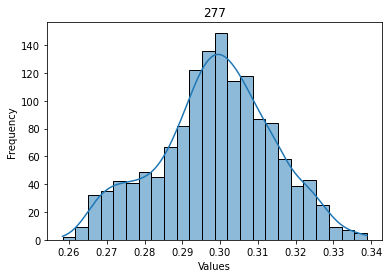

The number of conditions in 296 is 14


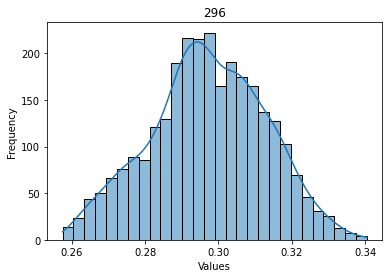

The number of conditions in 318 is 8


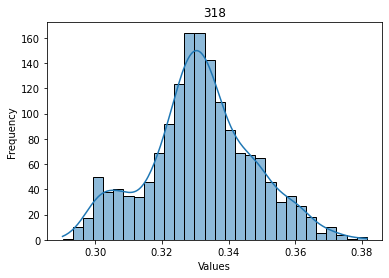

The number of conditions in 338 is 25


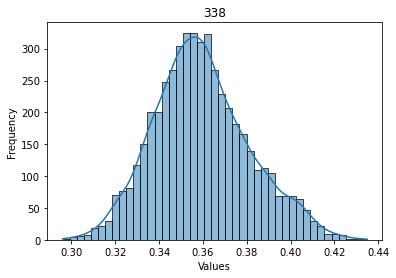

In [8]:
# Temperature comparison

# for every temperture accumulate all the RMSD for each frame (replicas averaged) 
# 54 conditions allocated into four temperatures, each condition has 200 frames

import seaborn as sns
import matplotlib.pyplot as plt

# to save all the four temperatures
result = []

column = list(df_avg.columns)

#loop over temperature

for i in ['277','296','318','338']: 
    

    temp = []
    
    for j in column:
        
        # match temp with the conditions in the column
        if re.search(i, j):
            
            # append the condition that matches the temp into the list
            temp.append(df_avg[j])
        
    
    
    # change the list into a dataframe
    merge = pd.DataFrame(temp)
    
    # transpose the matrix
    merge = merge.T

    #reset index
    merge = merge.reset_index(drop=True)
    
    
    print('The number of conditions in ' + str(i) + ' is ' + str(len(merge.columns)))
    
    # Flatten the DataFrame and convert it to a 1D array
    data = merge.values.flatten()
    

    # Create a distribution plot using Seaborn
    sns.histplot(data, kde=True)  # You can also use sns.distplot(data) for older Seaborn versions

    # Set labels and title
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(i)

    # Show the plot
    plt.show()
    
    
    # append the data array to the final list (list consists of four arrays)
    result.append(data)


# concatenate the four arrays into a dataframe
temp_rmsd = pd.DataFrame(result)

# transpose the matrix to make the temperature condition as columns
temp_rmsd = temp_rmsd.T

# Assign names to the columns
temp_rmsd.columns = ['277','296','318','338']


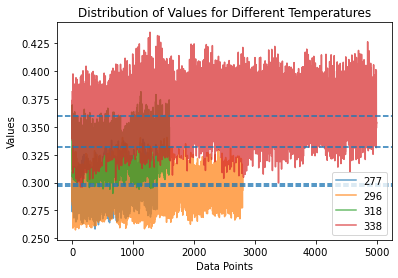

In [105]:
# matplotlib
# Plot the frequency of all the runs under different temps 

import matplotlib.pyplot as plt
import pandas as pd

# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Plot the distribution lines for each column
for column in temp_rmsd.columns:
    ax.plot(temp_rmsd[column], label=column, alpha=0.7)
    
    
# Calculate and plot the mean values
mean_values = temp_rmsd.mean()
for mean_value in mean_values:
    ax.axhline(mean_value, linestyle='--')


# Add labels and a legend
ax.set_xlabel('Data Points')
ax.set_ylabel('Values')
ax.set_title('Distribution of Values for Different Temperatures')
ax.legend()

# Save the plot to a file (e.g., PNG format)
# plt.savefig('matplot_distribution_plot.png')

# Show the plot
plt.show()

/Users/wintermute/opt/anaconda3/envs/MD/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/Users/wintermute/opt/anaconda3/envs/MD/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/Users/wintermute/opt/anaconda3/envs/MD/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibilit

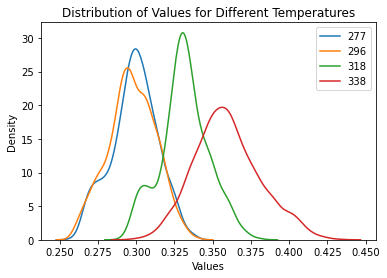

In [94]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Plot distribution plots for each column
for column in temp_rmsd.columns:
    sns.distplot(temp_rmsd[column], hist=False, label=column, ax=ax)

# Add labels and a legend
ax.set_xlabel('Values')
ax.set_ylabel('Density')
ax.set_title('Distribution of Values for Different Temperatures')
ax.legend()

# Save the plot to a file (e.g., PNG format)
plt.savefig('sns_distribution_plot.png')

# Show the plot
plt.show()

In [73]:
merge

,3_5_338_250,9_338_0,3_5_338_200,8_338_500,8_338_0,4_5_338_0,9_338_300,4_5_338_200,8_338_300,8_338_200,...,9_338_200,4_5_338_150,4_5_338_100,3_5_338_150,9_338_400,8_338_400,4_5_338_50,9_338_100,9_338_500,3_5_338_100
0,0.381437,0.350436,0.339380,0.373954,0.337634,0.355502,0.370125,0.364403,0.357307,0.328912,...,0.338436,0.342656,0.323416,0.383760,0.386946,0.344260,0.356339,0.318270,0.332936,0.372148
1,0.375392,0.346258,0.349248,0.388359,0.341744,0.358423,0.382486,0.367480,0.352225,0.324812,...,0.327960,0.334802,0.318330,0.386863,0.388181,0.338728,0.352098,0.340032,0.338252,0.366724
2,0.372633,0.338855,0.353673,0.378565,0.332785,0.346956,0.384382,0.366976,0.352844,0.329037,...,0.332024,0.329874,0.316536,0.381297,0.378782,0.339974,0.362312,0.316881,0.333067,0.351303
3,0.376701,0.337044,0.349923,0.392589,0.345494,0.348044,0.374387,0.352151,0.366676,0.321895,...,0.329771,0.347777,0.341019,0.378457,0.378831,0.345426,0.361409,0.319783,0.333390,0.354153
4,0.378384,0.347295,0.353473,0.377116,0.335550,0.361303,0.383176,0.352946,0.353061,0.314144,...,0.338560,0.353548,0.336392,0.378000,0.378144,0.351440,0.356077,0.321303,0.330673,0.347003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.382736,0.388953,0.365465,0.418109,0.351061,0.342409,0.362094,0.386242,0.375478,0.357242,...,0.335546,0.385896,0.335335,0.366995,0.405484,0.386559,0.363057,0.359816,0.355893,0.343441
196,0.377818,0.403198,0.367926,0.406966,0.341399,0.346270,0.357316,0.365954,0.371853,0.353477,...,0.329809,0.366972,0.341614,0.361631,0.389667,0.387558,0.359465,0.366852,0.348588,0.343622
197,0.377578,0.394458,0.363548,0.394460,0.339095,0.348080,0.353464,0.367788,0.369847,0.364732,...,0.328775,0.375320,0.325349,0.372004,0.383451,0.392143,0.364076,0.358627,0.348888,0.349943
198,0.361288,0.405631,0.358660,0.390275,0.340887,0.334136,0.344777,0.360611,0.378517,0.352094,...,0.333119,0.369611,0.335662,0.376944,0.396666,0.389234,0.362918,0.348164,0.357666,0.351700


The above table actually shows all the conditions that are at 338 K. 
There are 21 runs for 338 K. As is shown here.

In [60]:
dtale.show(temp)

## ΔRMSD calculation

dRMSD can mean a few things:

Normally this is a change in RMSD relative to some control, eg. RMSD variant - RMSD wild type, or RMSD(400K)-RMSD(300K).  Others use dRMSD = RMSD (time x) - RMSD (time = 0) and I think this is what you should use.

Some of the considerations were discussed today:

1)  time = 0 is still not a fully equilibrated system and we typically (in all atom) see 2-3 ns of rapid change at the start.  This should be ignored and so if RMSD (time x2 - time x1) is to be used, then time x1 should be consistent across all conditions/replicas and should be a point just after the 2-3ns rapid change.  Just make sure you end up using eg Frame 20 for all replicas and conditions.

2) Taking an average RMSD over the whole trajectory vs comparing just the average from the last eg 50-100ns?  The latter makes sense for what you are trying to do I think.

3) Averaging replicas.  Probably best to extract the dRMSD (last 50-100ns) for each replica and then obtain mean and Stdev for each condition.

The main aim is to compare whether the structural changes internal to the Fab are responding similarly in the CG to the All atom.  So you will need to apply the same analysis for both types of simulation.  The you can explore whether dRMSD is T, pH and IS dependent in similar ways.

In [3]:
# Drop the 1-20, 21-701 frames of RMSD

import re

d_rmsd_drop = {}
for df in d_rmsd: # loop over the dictionary. df is the key of the dictionary␣ ↪https://www.w3schools.com/python/python_dictionaries_loop.aspb
    
    t = d_rmsd[df].drop(range(0,20))
    
    d_rmsd_drop[df] = t.drop(range(21,701))


In [9]:
d_rmsd_drop

{'5_5_296_250_r2_rmsd.xvg':                 0          1
 20      2.0000000  0.2590909
 701    70.1000061  0.2527795
 702    70.2000046  0.2575802
 703    70.3000031  0.2534130
 704    70.4000015  0.2702456
 ...           ...        ...
 996    99.6000061  0.2647788
 997    99.7000046  0.2610774
 998    99.8000031  0.2554934
 999    99.9000015  0.2629577
 1000  100.0000076  0.2843663
 
 [301 rows x 2 columns],
 '9_338_200_r3_rmsd.xvg':                 0          1
 20      2.0000000  0.2766835
 701    70.1000061  0.2949415
 702    70.2000046  0.3021761
 703    70.3000031  0.3311365
 704    70.4000015  0.3230509
 ...           ...        ...
 996    99.6000061  0.3300312
 997    99.7000046  0.3248470
 998    99.8000031  0.3131919
 999    99.9000015  0.3404690
 1000  100.0000076  0.3703406
 
 [301 rows x 2 columns],
 '5_5_296_250_r3_rmsd.xvg':                 0          1
 20      2.0000000  0.2246536
 701    70.1000061  0.3193945
 702    70.2000046  0.3128167
 703    70.3000031  0.29892

In [31]:
# calculate the average of all the last 300 frames for each replica

d_avg = {}

for key in d_rmsd_drop:
    
    # drop the first row so as to calcuate the average of all the last 300 frames for each replica
    data = d_rmsd_drop[key].drop(range(20,21))
    
    # change the dataframe to numeric
    data = data.apply(pd.to_numeric)
    whole_data = d_rmsd_drop[key].apply(pd.to_numeric)
    
    # average all the rows
    frame_avg = data.mean(axis=0)
    
    # get the RMSD value of frame 20 (t=0)
    t_0 = whole_data.iloc[0,1]
    
    # calculate the ΔRMSD
    delta_rmsd = frame_avg[1] - t_0
    
    # save the average value and the RMSD (t = 0, i.e. 20th frame) into a dictionary
    d_avg[key] = [delta_rmsd]

In [55]:
import numpy as np

# combine all the replicas by condition

replica_avg = []

for i in run54:
    
    mean_each_run = []
    
    for key in d_avg:
        
        if re.search(i, key):
            
            # add detla rmsd to the list
            mean_each_run.append(d_avg[key])
    
    # calculate mean value for a list
    mean_replicas = np.mean(mean_each_run)
    
    std_replicas = np.std(mean_each_run)
    
    # append the mean value and condition name to a list
    replica_avg.append([i,mean_replicas,std_replicas])


df_replica_avg = pd.DataFrame(replica_avg)
df_replica_avg.columns =['Condition','mean','std']

In [57]:
# save the dataframe to an excel file

#df_replica_avg.to_excel("DeltaRMSD100923.xlsx")

## Comparison of the CG and AT simulations

I guess in this sense that the condition name is not important anymore. We can just plot all the values to the canvas, with CG value on the x axis and AT value on the y axis. 

## RMSF

#### Calculate the RMSF mean across the six replicas

##### Get the 54 condition name

In [6]:
# define a function to clean the filename so as to get the 54 condition names

import re

pattern_loop = r'loop\d{1}'  # Pattern to remove 'loop' followed by a digit
pattern_rmsd = r'rmsd'  # Pattern to remove 'rmsd'

def clean_filename(filename):
    # Remove the '.xvg' extension
    filename = filename.replace('.xvg', '')
    
    # get rid of i.g. _r2
    filename = re.sub(r'r\d{1}', '', filename) 

    # Remove 'loop' followed by a digit
    filename = re.sub(pattern_loop, '', filename, flags=re.IGNORECASE)

    # Remove 'rmsd'
    filename = re.sub(pattern_rmsd, '', filename, flags=re.IGNORECASE)
    
    # Remove Replicas
    filename = re.sub(r'Replicas', '', filename) 
    
    # Remove protonation_pH3_5 & protonation_pH4_5
    filename = re.sub(r'protonation_pH3_5', '', filename) 
    filename = re.sub(r'protonation_pH4_5', '', filename)   

    # Remove any non-numeric characters except underscores
    #filename = re.sub(r"[^0-9_]", "", filename)

    # Remove leading and trailing underscores
    filename = filename.strip('_')

    return filename

# apply the function to the list and append the names into a dataframe

files = []
for file in rmsd:
    
    
    cleaned_filename = clean_filename(file)
    files.append(cleaned_filename) # append all the filenames into a list

    
# remove duplicate names

# Convert the list to a set to remove duplicates
unique_run54 = set(files)

# Convert the set back to a list (if needed)
run54 = list(unique_run54)

In [7]:
# calculat the mean RMSF for 17 replicas loop over conditions 

rmsf_avg_replica = []

for i in run54:
    
    rmsf_avg = []
    
    for df in d_rmsf:
        
        if re.search(i, df):
            
            data = d_rmsf[df]
            
            # convert all the columns into numeric type
            data = data.apply(pd.to_numeric)
            
            # Assign column names
            data.columns = ['Residue', 'RMSF']
            
            rmsf_avg.append(data['RMSF'])
            
          
    # concatenate the list elements into one dataframe
    
    df_rmsf_avg = pd.concat(rmsf_avg, axis= 1)
    
    # calculate mean along each row
    df_rmsf_mean = df_rmsf_avg.mean(axis = 1)
    
    
    rmsf_avg_replica.append(df_rmsf_mean)
    
# concatate all the list elements into a dataframe
df_rmsf_avg_replica = pd.concat(rmsf_avg_replica, axis =1)

# assign the column name with the condition name list
df_rmsf_avg_replica.columns = run54

#### Further clean the data to remove duplicated condition names

In [8]:
# delete the repeated replica conditions such as 318_4_5_150M_2, 318_4_5_150M_3....
## Perhaps there's no need to perform this cell; after all, after the join = inner command, those conditions below will just be dropped

# List of column names to drop
columns_to_drop = ['318_4_5_150M_2', '318_4_5_150M_3','318_4_5_150M_4','296_4_5_50M_2','338_4_5_250M_2']

# Use df.drop to remove the specified columns

df_rmsf_avg_replica = df_rmsf_avg_replica.drop(columns_to_drop, axis=1)

#### Correlation with aggregation kinetics

In [9]:
import pandas as pd

# read the aggregation kinetics data; set the first column as the index 

agg = pd.read_excel("AggregationKinetics54conditions.xlsx", index_col= 0)

In [10]:
# join the two dataframes together

# Use pd.concat to concatenate them by rows
rmsf_agg = pd.concat([df_rmsf_avg_replica, agg], axis=0, join='inner')

# transpose the matrix

rmsf_agg = rmsf_agg.T

### Pearson regression

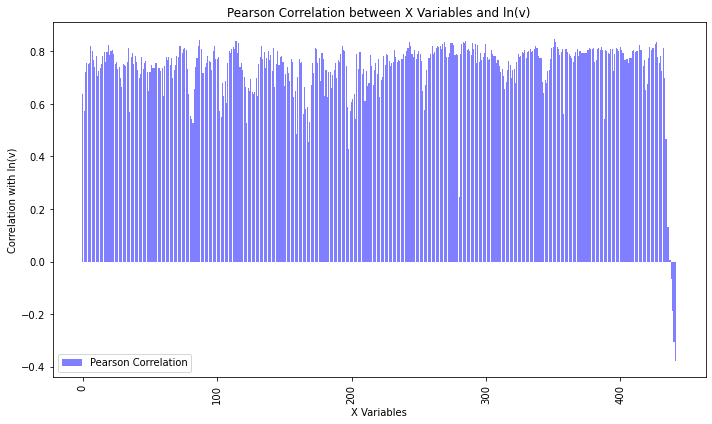

In [14]:
#Plot a bar chart

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


# X variables are columns 0 to 441, and Y variable is 'ln(v)'
X_columns = rmsf_agg.columns[:442]
Y_column = 'ln(v)'

# Create empty lists to store correlations and p-values
correlations = []
p_values = []

# Loop through each X variable and calculate Pearson correlation
for x_var in X_columns:
    correlation, p_value = pearsonr(rmsf_agg[x_var], rmsf_agg[Y_column])
    correlations.append(correlation)
    p_values.append(p_value)

# Create a bar plot for correlations
plt.figure(figsize=(10, 6))
plt.bar(X_columns, correlations, color='b', alpha=0.5, label='Pearson Correlation')
plt.xlabel('X Variables')
plt.ylabel('Correlation with ln(v)')
plt.title('Pearson Correlation between X Variables and ln(v)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

### PCA

Explained Variance Ratio:
[0.81118758 0.0250122  0.0213293  0.01673062 0.01265273 0.01037179
 0.0079054  0.00744546 0.00662832 0.00583004]
Loadings for the first 10 components:
        0         1         2         3         4         5         6    \
0  0.033033  0.029074  0.042848  0.044256  0.047063  0.048294  0.050683   
1 -0.026572 -0.025745 -0.037477 -0.041685 -0.053693 -0.035564 -0.011696   
2  0.026362  0.032115  0.005533  0.024738 -0.004507 -0.022603 -0.023451   
3 -0.120223 -0.115136 -0.087239 -0.012786  0.037928  0.046867  0.006651   
4 -0.046693 -0.063074 -0.050662 -0.039316 -0.080168 -0.046527 -0.056932   
5  0.011306  0.003199  0.047870  0.035186  0.043183 -0.019969  0.023295   
6 -0.055252 -0.065506 -0.062649 -0.075865 -0.042175 -0.034879 -0.003684   
7  0.036914  0.055782 -0.021256 -0.090069 -0.069657 -0.045453  0.005381   
8 -0.295926 -0.329547 -0.202387 -0.121062 -0.038977 -0.041852 -0.000336   
9  0.133987  0.114462 -0.016379 -0.054149 -0.017929 -0.061091 -0.025863  

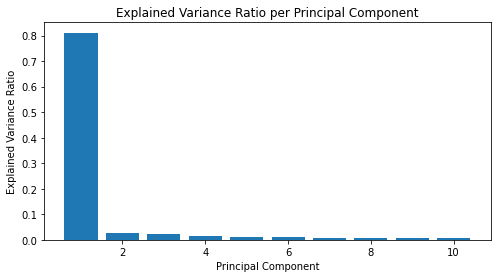

In [33]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# Standardize the data (mean=0, variance=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(rmsf_feature)

# Perform PCA with the desired number of components (e.g., 10)
num_components = 10
pca = PCA(n_components=num_components)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame to store the principal components
principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, num_components + 1)])

# Optionally, you can explore the explained variance ratio to see how much variance is explained by each component
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:")
print(explained_variance_ratio)

# Access the loadings (contributions) of each feature to each component
loadings = pca.components_

# Create a DataFrame to display the loadings
loadings_df = pd.DataFrame(loadings, columns=rmsf_feature.columns)

# Print the loadings for the first 'n_components' components
print("Loadings for the first", num_components, "components:")
print(loadings_df)

# Plot the explained variance ratio to decide the number of components
plt.figure(figsize=(8, 4))
plt.bar(range(1, num_components + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio per Principal Component')
plt.show()

Positive loadings mean that an increase in the original variable is associated with an increase in the principal component score.

Negative loadings mean that an increase in the original variable is associated with a decrease in the principal component score.

#### The contribution of each component 

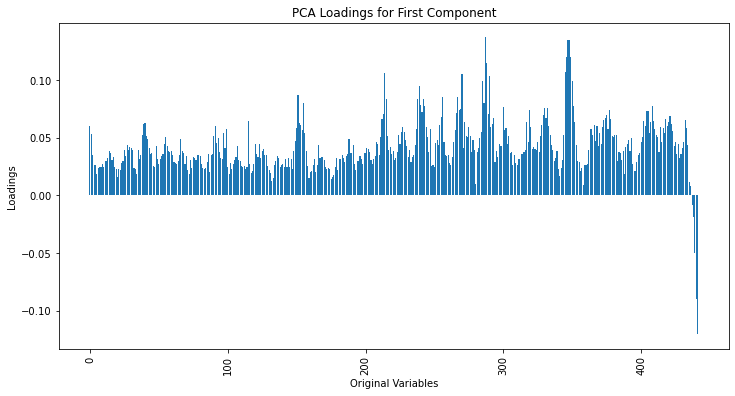

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

# Assuming you have already loaded your data into a DataFrame called 'rmsf_agg'
# Extract the feature matrix (442 residues)
X = rmsf_agg.iloc[:, 0:442]

# Perform PCA with the desired number of components (e.g., 10)
n_components = 10
pca = PCA(n_components=n_components)
pca.fit(X)

# Get the loadings
loadings = pca.components_.T  # Transpose to have one row per original variable

# Create a DataFrame to hold the loadings
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(n_components)], index=X.columns)

# Plot the loadings for the first component
plt.figure(figsize=(12, 6))
plt.bar(loadings_df.index, loadings_df['PC1'])  # Change 'PC1' to the desired component
plt.xlabel('Original Variables')
plt.ylabel('Loadings')
plt.title('PCA Loadings for First Component')
plt.xticks(rotation=90)
plt.show()


### PLS

#### Cross validation to choose the PLS component

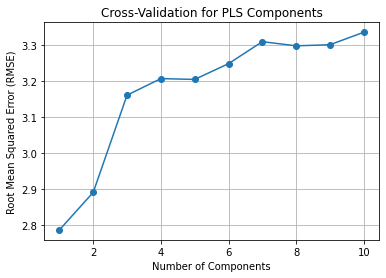

In [16]:
import pandas as pd
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

X = rmsf_agg.iloc[:, 0:442]  # Select the columns 0 to 441 as predictor variables (X)
Y = rmsf_agg['ln(v)']  # Assuming 'ln(v)' is your target variable

# Initialize lists to store cross-validation results
num_components_list = []
rmse_list = []

# Define a range of candidate numbers of components to try
component_range = range(1, 11)  # You can adjust the range as needed

# Perform cross-validation for different numbers of components
for num_components in component_range:
    # Initialize PLS model
    pls = PLSRegression(n_components=num_components)
    
    # Perform cross-validation and get predicted Y values
    predicted_Y = cross_val_predict(pls, X, Y, cv=5)  # 5-fold cross-validation
    
    # Calculate RMSE for the current number of components
    rmse = np.sqrt(mean_squared_error(Y, predicted_Y))
    
    # Store results in lists
    num_components_list.append(num_components)
    rmse_list.append(rmse)

# Plot the RMSE values for different numbers of components
plt.plot(num_components_list, rmse_list, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Cross-Validation for PLS Components')
plt.grid(True)
#plt.savefig("Cross-ValidationPLSComponents1200923.png")
plt.show()

One possible explanation of the chart: Underfitting (Fewer Components): Initially, with a small number of components (e.g., 1 to 4), the model might be underfitting the data, meaning it's too simplistic to capture the underlying patterns. As you increase the number of components, the model becomes more complex and starts to fit the data better, reducing RMSE.

Optimal Complexity (Flat Region): There's often an optimal level of complexity where the model neither underfits nor overfits. During this phase, the RMSE remains relatively constant as you add more components.

Overfitting (More Components): Beyond a certain point, adding more components can lead to overfitting. The model starts to capture noise in the data, which results in an increase in RMSE because it doesn't generalize well to new, unseen data.

#### PLS - One variable

Mean Squared Error: 9.060133026957269
R-squared: 0.5869664298473003


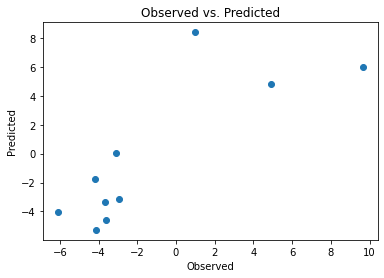

In [19]:
import pandas as pd
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

X = rmsf_agg.iloc[:, 0:442]  # Select the columns 0 to 441 as predictor variables (X)
Y = rmsf_agg['ln(v)']  # Assuming 'ln(v)' is your target variable

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

n_components = 1  # Number of PLS components, you can adjust this value
pls = PLSRegression(n_components=n_components)
pls.fit(X_train, Y_train)

Y_pred = pls.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

plt.scatter(Y_test, Y_pred)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Observed vs. Predicted')
#plt.savefig("PLS1_observed_predicted120923.png")
plt.show()

#### PLS2 - Two Y variables

RMSE for Tm: 7.430284448085132
RMSE for ln(v): 2.9794572835215964
R-squared (R²) for Tm: -0.3279735145422995
R-squared (R²) for ln(v): 0.619081927553368


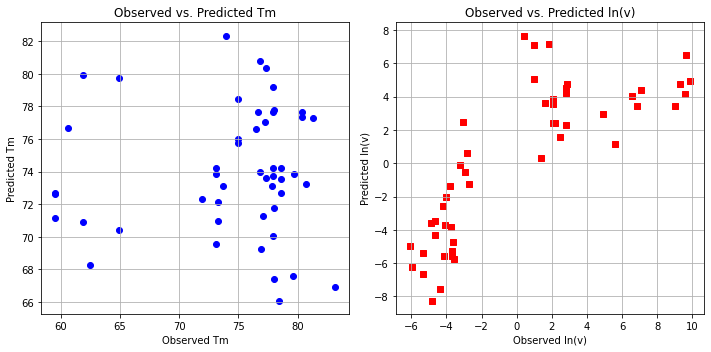

In [22]:
import pandas as pd
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict  # Corrected import
import matplotlib.pyplot as plt


# Separate the predictor variables (X) and the target variables (Tm and ln(v))
X = rmsf_agg.iloc[:, 0:442]  # Assuming columns 0 to 441 are your predictor variables
Y = rmsf_agg[['Tm', 'ln(v)']]  # Assuming 'Tm' and 'ln(v)' are your target variables

# Initialize MPLS (PLS2) model with the optimal number of components (e.g., 5)
num_components = 5
pls = PLSRegression(n_components=num_components)

# Perform cross-validation and get predicted Y values
predicted_Y = cross_val_predict(pls, X, Y, cv=5)  # 5-fold cross-validation

# Calculate RMSE for each target variable separately
rmse = np.sqrt(mean_squared_error(Y, predicted_Y, multioutput='raw_values'))

# Calculate R-squared (R²) for each target variable separately
r_squared = r2_score(Y, predicted_Y, multioutput='raw_values')

# Print RMSE and R-squared values for 'Tm' and 'ln(v)'
print("RMSE for Tm:", rmse[0])
print("RMSE for ln(v):", rmse[1])
print("R-squared (R²) for Tm:", r_squared[0])
print("R-squared (R²) for ln(v):", r_squared[1])

# Plot observed vs. predicted values for 'Tm'
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(Y['Tm'], predicted_Y[:, 0], c='b', marker='o', label='Tm')
plt.xlabel('Observed Tm')
plt.ylabel('Predicted Tm')
plt.title('Observed vs. Predicted Tm')
plt.grid(True)

# Plot observed vs. predicted values for 'ln(v)'
plt.subplot(1, 2, 2)
plt.scatter(Y['ln(v)'], predicted_Y[:, 1], c='r', marker='s', label='ln(v)')
plt.xlabel('Observed ln(v)')
plt.ylabel('Predicted ln(v)')
plt.title('Observed vs. Predicted ln(v)')
plt.grid(True)

plt.tight_layout()
#plt.savefig('PLS2_observed_predicted120923.png')
plt.show()

#### The contributions of each variable (X1 to X442) to each of the five PLS components

In [31]:
import pandas as pd
import numpy as np
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt

# Separate the predictor variables (X) and the target variables (Tm and ln(v))
X = rmsf_agg.iloc[:, 0:442]  # Assuming columns 0 to 441 are your predictor variables

# Initialize MPLS (PLS2) model with the desired number of components (e.g., 5)
num_components = 5
pls = PLSRegression(n_components=num_components)

# Fit the PLS model to your data
pls.fit(X, Y)  # Assuming Y is defined as in your previous code

# Access the X weights for each component
x_weights = pls.x_weights_

# Create a bar plot for each component
plt.figure(figsize=(12, 8))

# for component in range(num_components):
#     # Sort the variables by their absolute weight in descending order
#     sorted_weights = np.abs(x_weights[:, component])
#     sorted_indices = np.argsort(sorted_weights)[::-1]  # Reverse order to have highest weights first
#     sorted_weights = sorted_weights[sorted_indices]
#     sorted_variable_names = [f'X{idx + 1}' for idx in sorted_indices]

#     plt.subplot(2, 3, component + 1)  # Adjust the subplot layout as needed
#     plt.bar(range(len(sorted_weights)), sorted_weights)
#     plt.xticks(range(len(sorted_weights)), sorted_variable_names, rotation='vertical')
#     plt.title(f'Component {component + 1} Variable Contributions')
#     plt.xlabel('Variable')
#     plt.ylabel('Absolute Weight')

# plt.tight_layout()
# plt.show()

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

### Decision tree

Root Mean Squared Error (RMSE): 2.7453492436055136
R-squared (R2): 0.7303232995488983
Feature Importances:
    Feature  Importance
351     351    0.767340
198     198    0.132558
171     171    0.051470
249     249    0.012473
329     329    0.011692
..      ...         ...
144     144    0.000000
142     142    0.000000
141     141    0.000000
140     140    0.000000
221     221    0.000000

[442 rows x 2 columns]


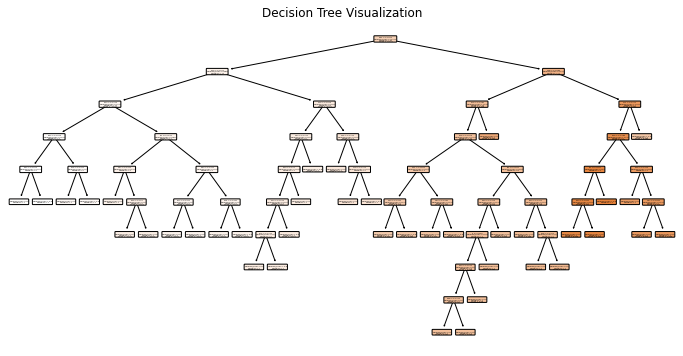

In [9]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load your dataset into a DataFrame
# Assuming X is your feature matrix and 'ln(v)' is your target variable

X = rmsf_agg.iloc[:, 0:442]
Y = rmsf_agg['ln(v)'] 

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create a Decision Tree Regressor model
tree_model = DecisionTreeRegressor(random_state=42)

# Fit the model on the training data
tree_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = tree_model.predict(X_test)

# Calculate RMSE and R-squared
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

# Analyze feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': tree_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importances)


# Visualisation
from sklearn.tree import plot_tree

# Assuming you have already fit a DecisionTreeRegressor model named 'tree_model'
plt.figure(figsize=(12, 6))
plot_tree(tree_model, filled=True, feature_names=rmsf_agg.columns[0:442], rounded=True)
plt.title("Decision Tree Visualization")
plt.show()


Decision tree creates a hierarchical structure of decisions based on feature values to predict the target variable. It's a supervised learning technique because it relies on labeled data to learn how to make these decisions


the decision tree algorithm will use the features (residues) to create a tree structure that predicts the ln(v) value based on the values of those residues. The splitting criteria are based on how well they separate the ln(v) values in your dataset, making it a supervised regression task

For regression tasks, mean squared error (MSE) is often used as the splitting criterion



   - Mean Decrease Impurity: For regression trees, the mean decrease impurity measures the reduction in the mean squared error (MSE) of predictions when a particular feature is used for splitting. In other words, it quantifies how much a feature contributes to the overall reduction in prediction error. Features that lead to greater reductions in MSE are considered more important.


In [16]:
## not successful 
## I want to plot something like P184 the prediction line vs actual data in the plot. There must be something different between our dataset, I was thinking where it is. 

import matplotlib.pyplot as plt

# Make predictions on the test data
predicted_Y = tree_model.predict(X)

# Assuming Y contains your observed Y values and predicted_Y contains the predicted Y values

# Create a scatter plot for the observed Y values
plt.scatter(, Y, label='Observed', color='blue', marker='o')

# # Create a line plot for the predicted Y values
# plt.plot(Y, predicted_Y, label='Predicted', color='red')

# # Add labels and a legend
# plt.xlabel('Observed Y')
# plt.ylabel('Predicted Y')
# plt.legend()

# # Show the plot
# plt.show()

SyntaxError: invalid syntax (3154293423.py, line 12)

#### Plot the training and validation performance (e.g., MSE or R-squared for regression trees) as a function of tree depth or the number of nodes. If the training error continues to decrease while the validation error starts increasing, it's a sign of overfitting. 


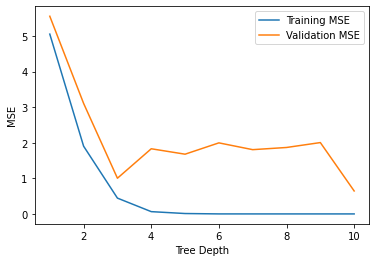

In [13]:
max_depth = 10  # Define the maximum depth to explore

depth_values = range(1, max_depth + 1)
train_errors = []
val_errors = []

for depth in depth_values:
    tree_model = DecisionTreeRegressor(max_depth=depth)
    tree_model.fit(X_train, y_train)
    y_train_pred = tree_model.predict(X_train)
    y_val_pred = tree_model.predict(X)
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    val_errors.append(mean_squared_error(Y, y_val_pred))

plt.plot(depth_values, train_errors, label='Training MSE')
plt.plot(depth_values, val_errors, label='Validation MSE')
plt.xlabel('Tree Depth')
plt.ylabel('MSE')
plt.legend()
plt.show()

#### Dealing with overfitting

Root Mean Squared Error (RMSE): 2.867923010641206
R-squared (R2): 0.7057047837955148
Feature Importances:
    Feature  Importance
351     351    0.783357
198     198    0.135325
13       13    0.052544
249     249    0.012733
344     344    0.010032
..      ...         ...
144     144    0.000000
143     143    0.000000
142     142    0.000000
141     141    0.000000
441     441    0.000000

[442 rows x 2 columns]


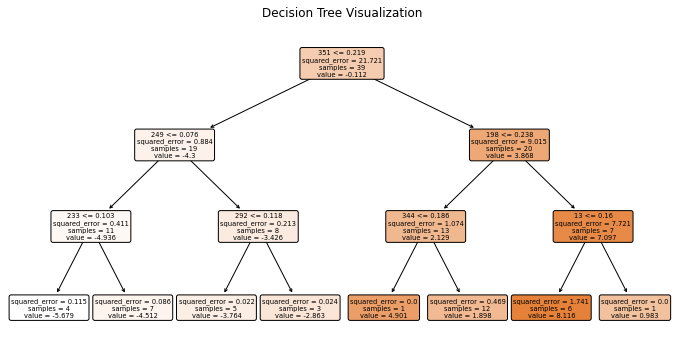

In [17]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load your dataset into a DataFrame
# Assuming X is your feature matrix and 'ln(v)' is your target variable

X = rmsf_agg.iloc[:, 0:442]
Y = rmsf_agg['ln(v)']

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create a Decision Tree Regressor model with maximum depth (solution 1)
max_depth = 3  # You can adjust this value
tree_model = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

# Fit the model on the training data
tree_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = tree_model.predict(X_test)

# Calculate RMSE and R-squared
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

# Analyze feature importances (solution 2)
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': tree_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importances)

# Visualisation (solution 3)
from sklearn.tree import plot_tree

# Assuming you have already fit a DecisionTreeRegressor model named 'tree_model'
plt.figure(figsize=(12, 6))
plot_tree(tree_model, filled=True, feature_names=rmsf_agg.columns[0:442], rounded=True)
plt.title("Decision Tree Visualization")
plt.show()


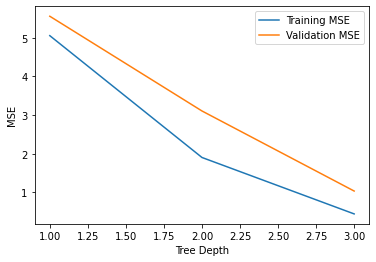

In [21]:
max_depth = 3  # Define the maximum depth to explore

depth_values = range(1, max_depth + 1)
train_errors = []
val_errors = []

for depth in depth_values:
    tree_model = DecisionTreeRegressor(max_depth=depth)
    tree_model.fit(X_train, y_train)
    y_train_pred = tree_model.predict(X_train)
    y_val_pred = tree_model.predict(X)
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    val_errors.append(mean_squared_error(Y, y_val_pred))

plt.plot(depth_values, train_errors, label='Training MSE')
plt.plot(depth_values, val_errors, label='Validation MSE')
plt.xlabel('Tree Depth')
plt.ylabel('MSE')
plt.legend()
plt.show()

### Random forest

Mean Squared Error (MSE): 5.807497823813907
R-squared (R2): 0.73524764452278


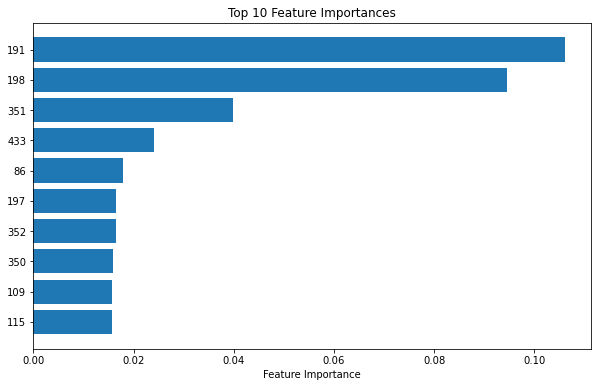

In [30]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load your dataset here; assuming you already have 'X' and 'Y' defined

# Split your data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust 'n_estimators' as needed

# Train the model on the training data
rf_model.fit(X_train, Y_train)

# Predict on the test data
Y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

# Visualize feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(range(10), feature_importances['Importance'][:10], align='center')
plt.yticks(range(10), feature_importances['Feature'][:10])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.show()


In [25]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming you have a trained Random Forest model called 'rf_model'
# You can access an individual decision tree using indexing, e.g., rf_model.estimators_[0]
# You can change the index to visualize different trees in the forest

tree_to_visualize = rf_model.estimators_[0]

# # Plot the decision tree
# plt.figure(figsize=(12, 6))
# plot_tree(tree_to_visualize, feature_names=X.columns, filled=True, rounded=True, fontsize=10)
# plt.title("Example Decision Tree from Random Forest")
# plt.show()


#### Assess overfitting based on the Random Forest

In [22]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load your dataset here; assuming you already have 'X' and 'Y' defined

# Step 1: Split your data into training, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# Step 2: Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust 'n_estimators' as needed

# Train the model on the training data
rf_model.fit(X_train, Y_train)

# Step 3: Validate the model's performance on the validation set
Y_val_pred = rf_model.predict(X_val)

# Calculate validation MSE and R2
val_mse = mean_squared_error(Y_val, Y_val_pred)
val_r2 = r2_score(Y_val, Y_val_pred)

print(f"Validation Mean Squared Error (MSE): {val_mse}")
print(f"Validation R-squared (R2): {val_r2}")

# Step 4: Evaluate the model's performance on the test set
Y_test_pred = rf_model.predict(X_test)

# Calculate test MSE and R2
test_mse = mean_squared_error(Y_test, Y_test_pred)
test_r2 = r2_score(Y_test, Y_test_pred)

print(f"Test Mean Squared Error (MSE): {test_mse}")
print(f"Test R-squared (R2): {test_r2}")

# Step 5: Compare performance on training, validation, and test sets
Y_train_pred = rf_model.predict(X_train)

# Calculate training MSE and R2
train_mse = mean_squared_error(Y_train, Y_train_pred)
train_r2 = r2_score(Y_train, Y_train_pred)

print(f"Training Mean Squared Error (MSE): {train_mse}")
print(f"Training R-squared (R2): {train_r2}")


Validation Mean Squared Error (MSE): 4.10613154692434
Validation R-squared (R2): 0.818459731194427
Test Mean Squared Error (MSE): 5.590782643614238
Test R-squared (R2): 0.69620693112817
Training Mean Squared Error (MSE): 0.9931943736060491
Training R-squared (R2): 0.9605825717229136


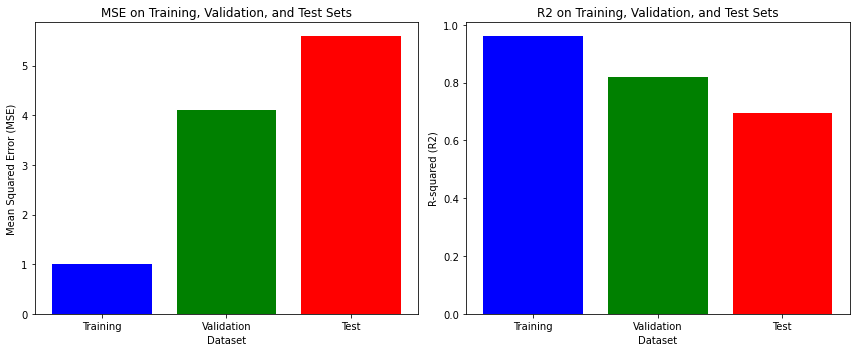

In [24]:
import matplotlib.pyplot as plt

# Define the metrics for each dataset (training, validation, test)
mse_values = [train_mse, val_mse, test_mse]
r2_values = [train_r2, val_r2, test_r2]
datasets = ['Training', 'Validation', 'Test']

# Create subplots for MSE and R2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Mean Squared Error (MSE)
ax1.bar(datasets, mse_values, color=['blue', 'green', 'red'])
ax1.set_xlabel('Dataset')
ax1.set_ylabel('Mean Squared Error (MSE)')
ax1.set_title('MSE on Training, Validation, and Test Sets')

# Plot R-squared (R2)
ax2.bar(datasets, r2_values, color=['blue', 'green', 'red'])
ax2.set_xlabel('Dataset')
ax2.set_ylabel('R-squared (R2)')
ax2.set_title('R2 on Training, Validation, and Test Sets')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()
